# Jul 22nd, 2022 (Fig2, add indiv circles)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 128
perc = 20
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p20/Fig2_OCs

## Prepare (128)

In [3]:
num_k = 7
mice = Mice(nn)

## Results

In [4]:
final_perm={4: 6, 5: 4, 6: 5}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(7)
}

In [5]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.376,
    n_resamples=int(1e4),
    final_perm=final_perm,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 1min 33s, sys: 4.64 s, total: 1min 38s
Wall time: 1min 38s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'good_runs',
    'data4perm',
    'tests'
]

## Save dir

In [6]:
save_dir = pjoin(fig_dir, f"K{num_k}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p20/Fig2_OCs/K7

## OCs

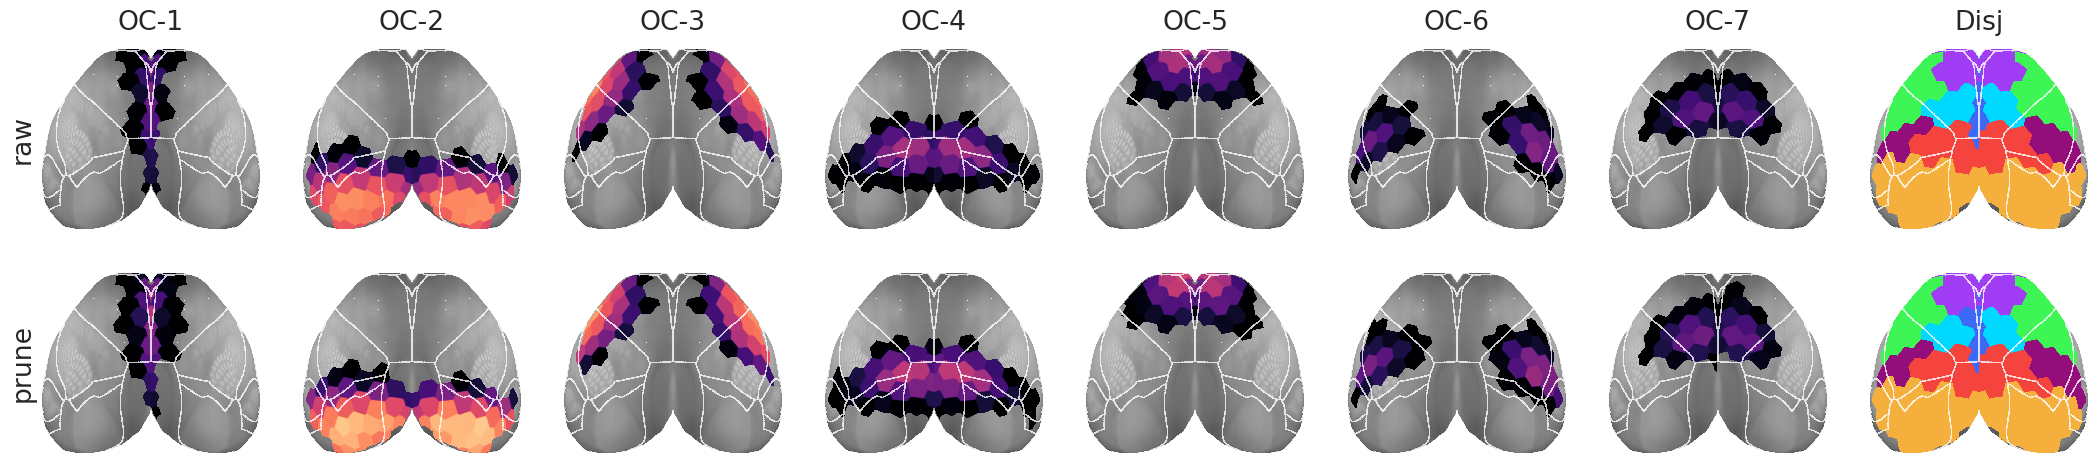

In [7]:
_ = bt.show(
    data={
        'raw': avg(results['bt_dict'][BOLD].run_pi),
        'prune': avg(results['bt_dict'][BOLD].pi_prune)},
    **show_kws(num_k),
)

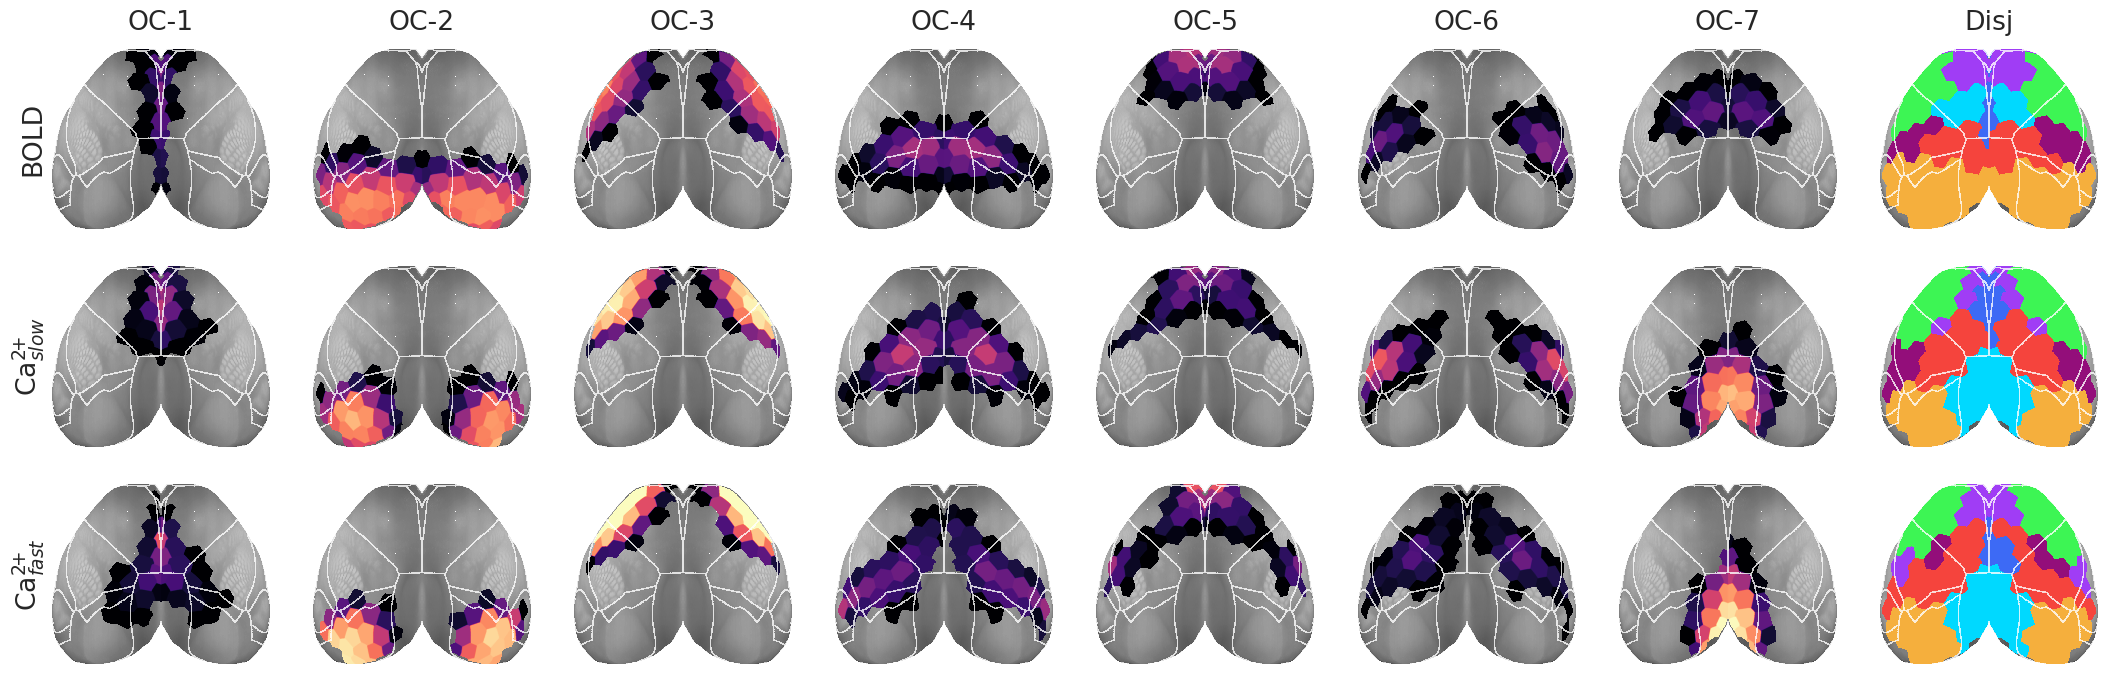

In [8]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

## *** tmp ***

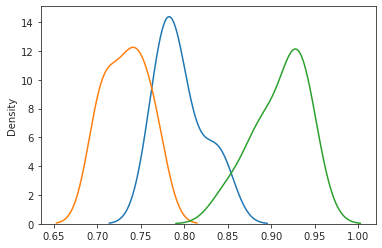

In [9]:
for k, v in results['sim_overall'].items():
    sns.kdeplot(v)

array([0.04310317, 0.04092436, 0.0317284 ])

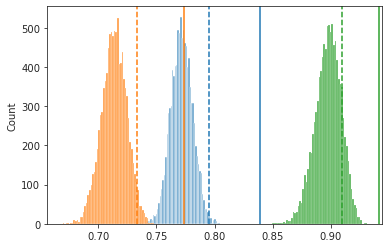

In [10]:
xx = []
yy = []
for i, (k, v) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(v, color=f"C{i}")
    _x = results['sim_overall'][k].mean()
    _y = cosine_sim(results['pi_sorted'])[-1][k].item()
    plt.axvline(_x, color=f"C{i}", ls='--')
    plt.axvline(_y, color=f"C{i}", ls='-')
    
    xx.append(_x)
    yy.append(_y)

xx = np.array(xx)
yy = np.array(yy)

yy - xx

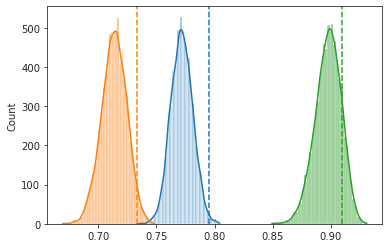

In [11]:
for i, (k, v) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(v, kde=True, color=f"C{i}")
    _x = results['sim_overall'][k].mean()
    plt.axvline(_x, color=f"C{i}", ls='--')

In [34]:
f = lambda a: avg(a, 3, 2)

In [35]:
asli = f(np.expand_dims(_cat_data(results['bt_dict']), 0))

In [36]:
asli.shape

(1, 10, 7, 152, 3)

In [37]:
x = {
    mode: asli[0][..., i] for
    i, mode in enumerate(results['bt_dict'])
}
sim, sim_overall = cosine_sim(x)

In [39]:
for k, v in sim_overall.items():
    print(k, v.mean())

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.7955980545058904

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.7332868725445623

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.9097792778354661

In [40]:
xx

array([0.79559805, 0.73328687, 0.90977928])

In [16]:
from analysis.final import _cat_data

boot = bootstrap(
    x=_cat_data(results['bt_dict']),
    n_resamples=100,
    statistic=lambda a: avg(a, 3, 2),
    skip=['d0'],
    dims=3,
)
boot.shape

(100, 10, 7, 152, 3)

In [23]:
sim_b = collections.defaultdict(list)
sim_overall_b = collections.defaultdict(list)
for b in range(len(boot)):
    x = {
        mode: boot[b][..., i] for
        i, mode in enumerate(results['bt_dict'])
    }
    sim, sim_overall = cosine_sim(x)
    for k, v in sim.items():
        sim_b[k].append(np.expand_dims(
            v, axis=0))
        sim_overall_b[k].append(np.expand_dims(
            sim_overall[k], axis=0))
sim_b = {
    k: np.concatenate(v)
    for k, v in sim_b.items()
}
sim_overall_b = {
    k: np.concatenate(v)
    for k, v in sim_overall_b.items()
}

In [29]:
data = []
for k, v in sim_overall_b.items():
    data.append(np.expand_dims(v.T, axis=-1))
data = np.concatenate(data, axis=-1)
data.shape

(10, 100, 3)

In [32]:
boot2 = bootstrap(
    x=data,
    n_resamples=100,
    statistic=lambda a: bn.nanmean(a, 1),
    dims=1,
)
boot2 = boot2.reshape(-1, len(results['bt_dict']))
boot2.shape

(10000, 3)

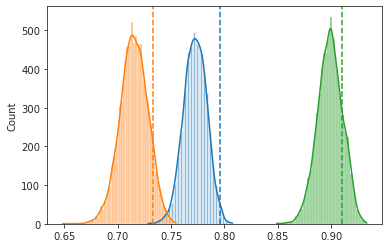

In [33]:
for i, (k, v) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(boot2[..., i], kde=True, color=f"C{i}")
    _x = results['sim_overall'][k].mean()
    plt.axvline(_x, color=f"C{i}", ls='--')

In [50]:
for i, (k, v) in enumerate(sim_overall.items()):
    se = sp_stats.bootstrap(
        data=(v,),
        statistic=bn.nanmean,
        n_resamples=100000,
        vectorized=False,
        random_state=42,
        method='BCa',
    ).standard_error
    se = np.round(se, 3)
    print(k, se, np.round(bn.nanstd(boot2[..., i], ddof=1), 3))

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.008 0.011

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.007 0.013

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.009 0.012

In [41]:
v

array([0.92984405, 0.92371295, 0.8484631 , 0.87905257, 0.89404358,
       0.92516697, 0.93907295, 0.94421255, 0.88900784, 0.92521621])

In [46]:

se

0.009206935539804126

0.011744764067484087

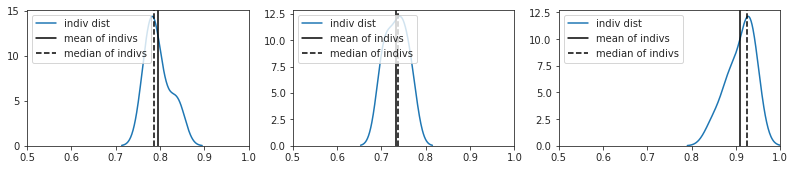

In [18]:
fig, axes = create_figure(1, 3, (13.5, 2.5))

for i, v in enumerate(sim_overall.values()):
    ax = axes[i]
    sns.kdeplot(v, label='indiv dist', ax=ax)
    ax.axvline(v.mean(), color='k', label='mean of indivs')
    ax.axvline(np.median(v), color='k', ls='--', label='median of indivs')
    # ax.axvline(v[-1], color='r', label='group')
    ax.legend(loc='upper left')
    ax.set_xlim(0.5, 1.0)
    ax.set_ylabel('')
plt.show()

In [19]:
x = np.concatenate([
    list(sim_overall.values())[0][:10].reshape(1, -1),
    list(sim_overall.values())[1][:10].reshape(1, -1),
    list(sim_overall.values())[2][:10].reshape(1, -1),
])
x.shape

(3, 10)

<AxesSubplot:ylabel='Count'>

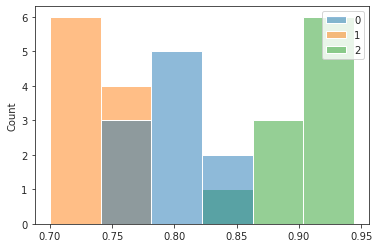

In [20]:
sns.histplot(x.T)

In [21]:
def statistic(x, y):
    return np.mean(x - y)

test = sp_stats.permutation_test(
    data=(x[0], x[1]),
    statistic=statistic,
    permutation_type='samples',
    n_resamples=int(1e6),
    batch=5,
)

In [22]:
test

PermutationTestResult(
    statistic=0.06231118196132809,
    pvalue=0.001953125,
    null_distribution=array([ 0.06231118,  0.04814384,  0.04378157, ..., -0.04378157,
       -0.04814384, -0.06231118])
)

In [23]:
len(test.null_distribution)

1024

<matplotlib.lines.Line2D object at 0x7f305edc8550>

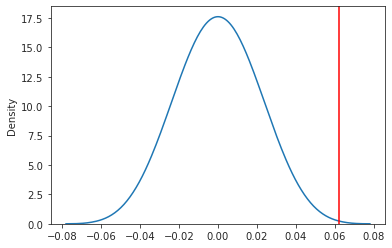

In [24]:
sns.kdeplot(test.null_distribution)
plt.axvline(test.statistic, color='r')

<AxesSubplot:ylabel='Density'>

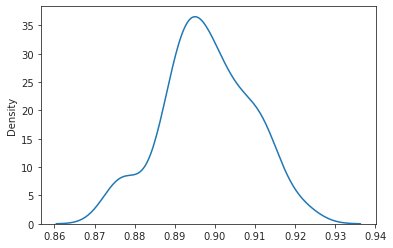

In [62]:
sns.kdeplot(v)

In [5]:
list(results)

[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'good_runs',
    'data4perm',
    'tests'
]

In [6]:
for k, x in results['sim_overall'].items():
    print(k, x.mean())

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.7955980545058904

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.7332868725445623

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.9097792778354663

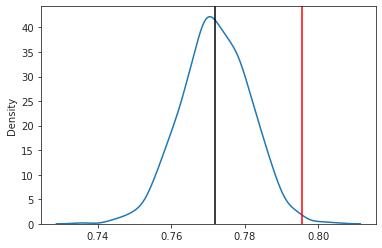

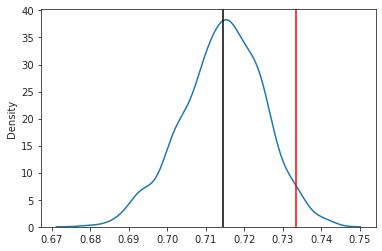

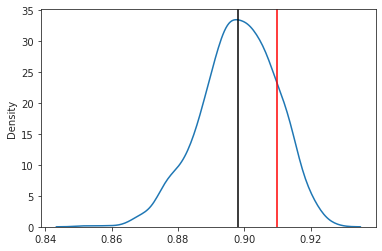

In [5]:
for k, x in results['sim_overall_b'].items():
    sns.kdeplot(x)
    plt.axvline(x.mean(), color='k')
    plt.axvline(results['sim_overall'][k].mean(), color='r')
    plt.show()

In [11]:
get_tval() * bn.nanstd(x, 0, ddof=1)

0.02576655960244439

In [10]:
for k, x in results['sim_overall'].items():
    se = bn.nanstd(results['sim_overall'][k], 0, ddof=1)
    print(k, np.round(x.mean() - get_tval() * se, 2), np.round(x.mean(), 2), np.round(x.mean() + get_tval() * se, 2))

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.73 0.8 0.86

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.68 0.73 0.79

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.84 0.91 0.98

In [11]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.376,
    n_resamples=int(1e2),
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 5.79 s, sys: 2.8 s, total: 8.59 s
Wall time: 8.66 s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'good_runs',
    'data4perm',
    'tests'
]

In [12]:
for k, x in results['sim_overall'].items():
    se = bn.nanstd(results['sim_overall'][k], 0, ddof=1)
    print(k, np.round(x.mean() - get_tval() * se, 2), np.round(x.mean(), 2), np.round(x.mean() + get_tval() * se, 2))

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.73 0.8 0.86

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.68 0.73 0.79

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.84 0.91 0.98

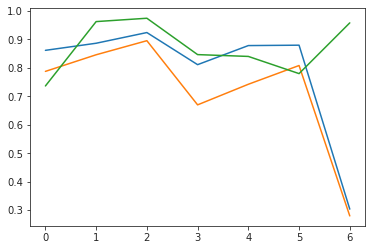

In [9]:
for k, v in results['sim'].items():
    s = v.mean(0).diagonal()
    plt.plot(s)

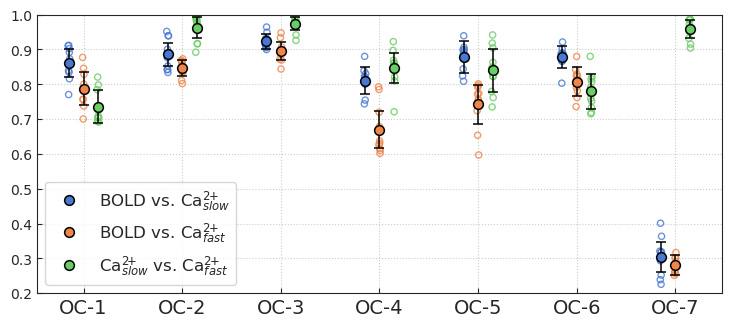

In [11]:
from figures.fig_ocs import similarity_point

fig, ax = similarity_point(results, False)
fig.savefig(pjoin(save_dir, 'test.pdf'), **kws_fig)

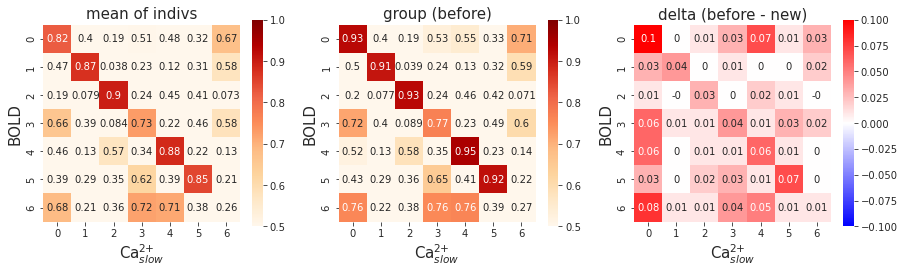

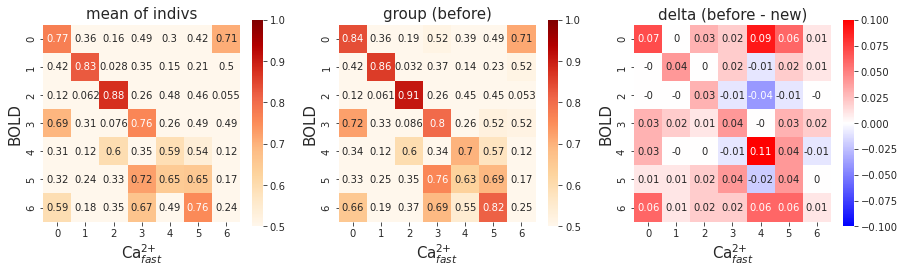

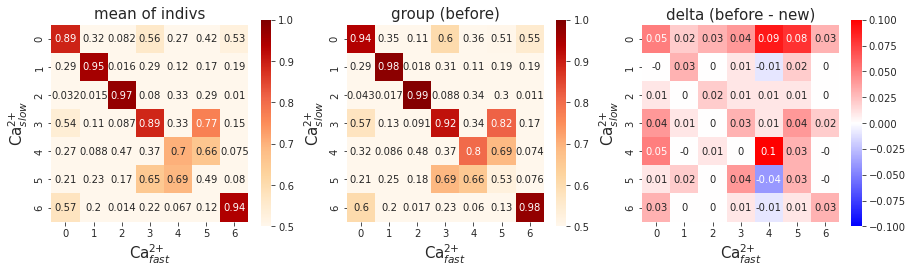

In [85]:
for (lbl_1, lbl_2), x in sim.items():
    fig, axes = create_figure(1, 3, (15, 3.8))
    sns.heatmap(x[:10].mean(0), vmin=0.5, vmax=1.0, cmap='OrRd', ax=axes[0], annot=True, square=True)
    sns.heatmap(x[-1], vmin=0.5, vmax=1.0, cmap='OrRd', ax=axes[1], annot=True, square=True)
    sns.heatmap(
        np.round(x[-1] - x[:10].mean(0), 2),
        vmin=-0.1, vmax=0.1, cmap='bwr', ax=axes[2], annot=True, square=True)
    
    axes[0].set_title('mean of indivs', fontsize=15)
    axes[1].set_title('group (before)', fontsize=15)
    axes[2].set_title('delta (before - new)', fontsize=15)
    
    for ax in axes.flat:
        ax.set_ylabel(lbl_1, fontsize=15)
        ax.set_xlabel(lbl_2, fontsize=15)

## Similarity plots

### Plot heatmap

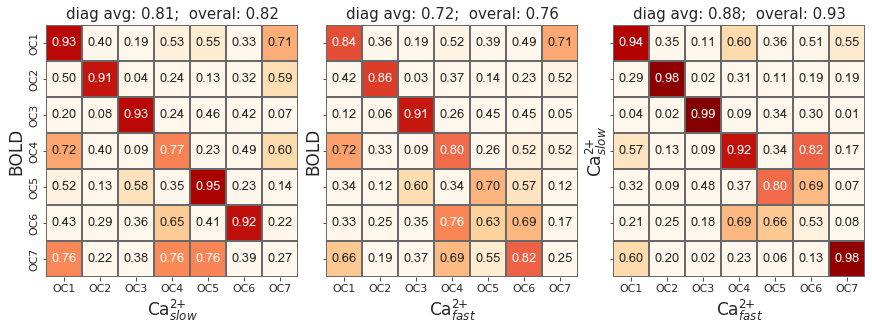

In [10]:
from figures.fig_ocs import similiarity_heatmap as go
_ = go(results['sim'], results['sim_overall'], True, True)
fig, _ = go(results['sim'], results['sim_overall'], False, False)

fig.savefig(pjoin(save_dir, 'sim_hm.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_hm.png'), **kws_fig)

### Different colormaps

In [11]:
_dir = pjoin(fig_dir, 'CMAPs')
os.makedirs(_dir, exist_ok=True)
print(_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig2_OCs/CMAPs

In [12]:
%%time

for cmap in plt.colormaps():
    for lw in [0, 0.5, 0.8]:
        if lw == 0:
            fig, _ = go(
                results['sim'], results['sim_overall'], False, False,
                cmap=cmap,
                linewidths=lw,
            )
            fig.suptitle(f'{cmap};   lw = {lw}', y=1.0, fontsize=17)
            fig.savefig(pjoin(_dir, f'{cmap}_lw{lw}.pdf'), **kws_fig)
        else:
            for lc in ['w', 'dimgrey']:
                fig, _ = go(
                    results['sim'], results['sim_overall'], False, False,
                    cmap=cmap,
                    linewidths=lw,
                    linecolor=lc,
                )
                fig.suptitle(f'{cmap};   lw = {lw}, lc = {lc}', y=1.0, fontsize=17)
                fig.savefig(pjoin(_dir, f'{cmap}_lw{lw}_lc{lc}.pdf'), **kws_fig)

CPU times: user 19min 29s, sys: 31.7 s, total: 20min 1s
Wall time: 20min 2s


### Plot line

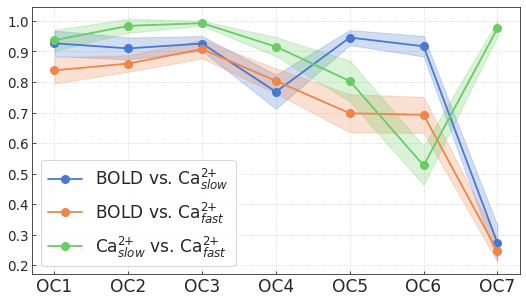

In [11]:
from figures.fig_ocs import similiarity_line as go
fig, _ = go(results['sim'], results['sim_b'], True)

fig.savefig(pjoin(save_dir, 'sim_ln.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_ln.png'), **kws_fig)

### Look at boot stuff

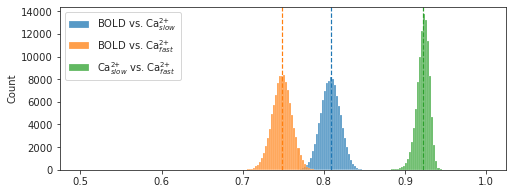

In [12]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.5, 1, 201),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.2)
ax.legend()
plt.show()

In [13]:
for k, v in results['sim_overall_b'].items():
    se = np.nanstd(v, 0, ddof=1)
    print(k, se, np.round(se * get_tval(), 3))

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.011936758293127065 0.027

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.01198247526832271 0.027

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.007855149850956415 0.018

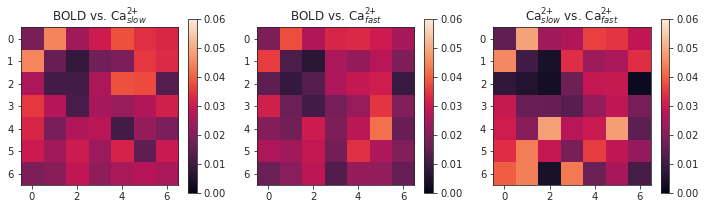

In [14]:
fig, axes = create_figure(1, 3, (12, 3.2))
for i, (k, v) in enumerate(results['sim_b'].items()):
    se = np.nanstd(v, 0, ddof=1)
    
    ax = axes[i]
    im = ax.imshow(se, cmap='rocket', vmin=0, vmax=0.06)
    ax.set_title(f"{k[0]} vs. {k[1]}")
    plt.colorbar(im, ax=ax)
plt.show()

### Perm test

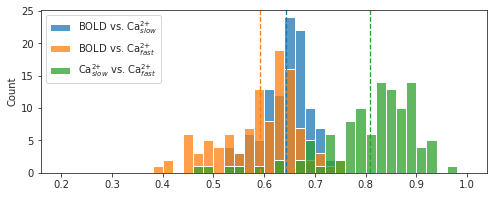

In [15]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['data4perm'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.2, 1, 41),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax,
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.3)
ax.legend()
plt.show()

In [ ]:
fig, axes = create_figure(1, 3, (12, 2.8), sharey='all')

for i, ((cond_1, cond_2), test) in enumerate(results['tests'].items()):
    ax = axes[i]   
    sns.histplot(test.null_distribution, kde=True, ax=ax)
    ax.axvline(test.statistic, color='r')
    title = f"cos({cond_1[0]},{cond_1[1]})\nvs.\ncos({cond_2[0]},{cond_2[1]})\n\n"
    title += f"pval = {test.pvalue:1.1e};  statistic = {test.statistic:.3f}\n"
    ax.set_title(title)
plt.show()

In [ ]:
multipletests([2e-5] * 3, alpha=0.001, method='bonferroni')[0]